In [1]:
%load_ext autoreload
%autoreload 2

### Preparing the Dataset

In [2]:
# First Defining directories
import os

DATA_DIR_PATH = os.path.join(os.getcwd(), 'data') # inputs of the model will be stored here

In [22]:
import torch
from torchvision.datasets import MNIST
from torchvision import transforms

# We usually normalize the image data with their mean and std. deviation so that the data has mean and std. deviation as 0.
# MNIST data has mean as 0.1307 and std. deviation as 0.3081.
# More information could be found here: https://datascience.stackexchange.com/questions/46228/how-mean-and-deviation-come-out-with-mnist-dataset

mean, std = 0.1307, 0.3081

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((mean, ), (std, ))
])

mnist_train_dataset = MNIST(root=DATA_DIR_PATH , train=True, download=True, transform=transform)

mnist_test_dataset  = MNIST(root=DATA_DIR_PATH , train=False, download=True, transform=transform)

# Since there 10 digits which would be used to classify. hence there are 10 classes.
n_classes = 10

## Common Setup

In [8]:
import torch
from torch.optim import lr_scheduler
import torch.optim as optim
from torch.autograd import Variable

from trainer import fit
import numpy as np

cuda = False #torch.cuda.is_available()

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

mnist_classes = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
colors        = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
              '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
              '#bcbd22', '#17becf']


def plot_embeddings(embeddings, targets, xlim=None, ylim=None):
    plt.figure(figsize=(10,10))

    for i in range(10):
        inds = np.where(targets == i)[0]
        plt.scatter(embeddings[inds, 0], embeddings[inds, 1], alpha=0.5, color=colors[i])

    if xlim:
        plt.xlim(xlim[0], xlim[1])
    if ylim:
        plt.ylim(ylim[0], ylim[1])
    plt.legend(mnist_classes)


def extract_embeddings(dataloader, model):
    with torch.no_grad():
        model.eval()
        embeddings = np.zeros((len(dataloader.dataset), 2))
        labels     = np.zeros(len(dataloader.dataset))

        k = 0

        for images, target in dataloader:
            if cuda:
                images = images.cuda()
            embeddings[k:k+len(images)] = model.get_embedding(images).data.cpu().numpy()
            labels[k:k+len(images)]     = target.numpy()
            k += len(images)
    return embeddings, labels

## Baseline: Classification with Softmax

We'll train the model for classification and use outputs of penultimate layer as embedding

In [5]:
# Set up the dataloaders
batch_size = 256
kwargs     = {'num_workers': 1, 'pin_memory': True} if cuda else {}

train_loader = torch.utils.data.DataLoader(mnist_train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
test_loader  = torch.utils.data.DataLoader(mnist_test_dataset, batch_size=batch_size, shuffle=False, **kwargs)

# Set up the network and training parameters
from networks import EmbeddingNet, ClassificationNet
from metrics import AccumulatedAccuracyMetric

embedding_net = EmbeddingNet()
model         = ClassificationNet(embedding_net, n_classes=n_classes)

if cuda:
    model.cuda()
    
loss_fn = torch.nn.NLLLoss()
lr      = 1e-2

optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs  = 20
log_interval = 50

In [6]:
fit(train_loader, test_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval, metrics=[AccumulatedAccuracyMetric()])

/home/theguywithblacktie/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:118: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Train: [0/60000 (0%)]	Loss: 2.381866	Accuracy: 10.546875
Train: [12800/60000 (21%)]	Loss: 2.833042	Accuracy: 18.926164215686274
Train: [25600/60000 (43%)]	Loss: 1.362871	Accuracy: 31.292543316831683
Train: [38400/60000 (64%)]	Loss: 0.849307	Accuracy: 44.983961092715234
Train: [51200/60000 (85%)]	Loss: 0.536867	Accuracy: 55.262748756218905
Epoch: 1/20. Train set: Average loss: 1.2561	Accuracy:60.375
Epoch: 1/20. Validation set: Average loss: 0.3109	Accuracy:92.96
Train: [0/60000 (0%)]	Loss: 0.324592	Accuracy: 92.1875
Train: [12800/60000 (21%)]	Loss: 0.349219	Accuracy: 92.34834558823529
Train: [25600/60000 (43%)]	Loss: 0.238793	Accuracy: 93.67264851485149
Train: [38400/60000 (64%)]	Loss: 0.214577	Accuracy: 94.42001241721854
Train: [51200/60000 (85%)]	Loss: 0.206596	Accuracy: 94.80332711442786
Epoch: 2/20. Train set: Average loss: 0.2424	Accuracy:95.03833333333333
Epoch: 2/20. Validation set: Average loss: 0.1599	Accuracy:96.31
Train: [0/60000 (0%)]	Loss: 0.197851	Accuracy: 96.09375
Train

Train: [51200/60000 (85%)]	Loss: 0.005525	Accuracy: 99.92032027363184
Epoch: 18/20. Train set: Average loss: 0.0060	Accuracy:99.915
Epoch: 18/20. Validation set: Average loss: 0.1089	Accuracy:99.04
Train: [0/60000 (0%)]	Loss: 0.034351	Accuracy: 99.609375
Train: [12800/60000 (21%)]	Loss: 0.005144	Accuracy: 99.93872549019608
Train: [25600/60000 (43%)]	Loss: 0.005057	Accuracy: 99.92651608910892
Train: [38400/60000 (64%)]	Loss: 0.006668	Accuracy: 99.92239238410596
Train: [51200/60000 (85%)]	Loss: 0.004928	Accuracy: 99.92032027363184
Epoch: 19/20. Train set: Average loss: 0.0057	Accuracy:99.91666666666667
Epoch: 19/20. Validation set: Average loss: 0.1110	Accuracy:99.04
Train: [0/60000 (0%)]	Loss: 0.002891	Accuracy: 100.0
Train: [12800/60000 (21%)]	Loss: 0.005739	Accuracy: 99.90042892156863
Train: [25600/60000 (43%)]	Loss: 0.004440	Accuracy: 99.92264851485149
Train: [38400/60000 (64%)]	Loss: 0.004300	Accuracy: 99.93015314569537
Train: [51200/60000 (85%)]	Loss: 0.007983	Accuracy: 99.91837686

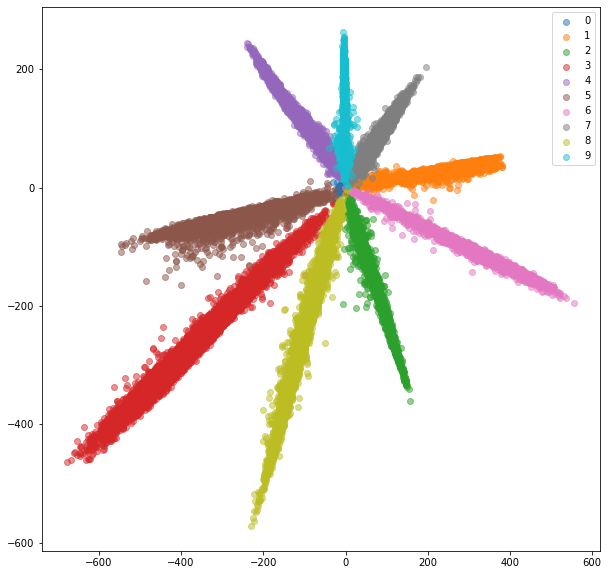

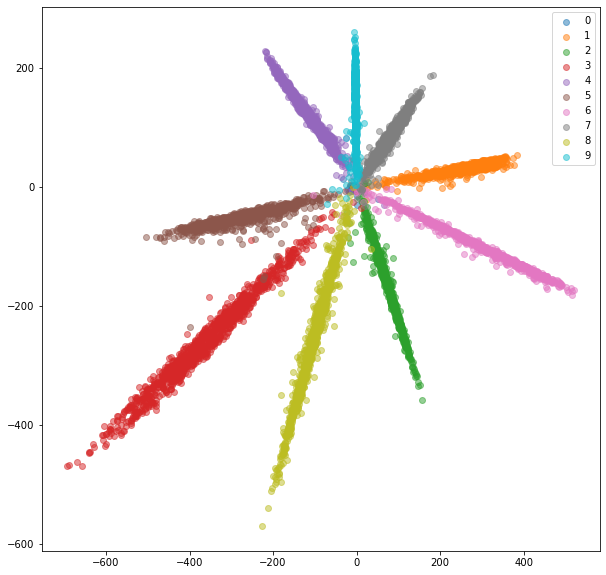

In [9]:
train_embeddings_baseline, train_labels_baseline = extract_embeddings(train_loader, model)
plot_embeddings(train_embeddings_baseline, train_labels_baseline)
val_embeddings_baseline, val_labels_baseline = extract_embeddings(test_loader, model)
plot_embeddings(val_embeddings_baseline, val_labels_baseline)

The above embeddings looks seperable but yet they are not separated enough.

### Siamese Networks

Now we'll train a siamese network that takes a pair of images as input and trains the model such that the embedding outputs of the model is minimum if input pair belong to same class or maximum if input pair belong to different classes. Loss function used in this case is Contrastive Loss Function. Hence, it is also called as **contrastive learning**.

$$
L_{contrastive}(x_{0}, x_{1}, y) = \frac{1}{2}\|f(x_{0}) - f(x_{1}) \|_{2}^{2} + \frac{1}{2}(1-y)\{max(0,m-\|f(x_{0}) - f(x_{1})\|_{2})\}^{2}
$$

$x_{0}, x_{1}$ are input pairs of image and $y$ is either 1 or 0 depicting whether the input pair has same label or different. 

In [11]:
from datasets import SiameseMNIST

siamese_train_dataset = SiameseMNIST(mnist_train_dataset)
siamese_test_dataset  = SiameseMNIST(mnist_test_dataset)

batch_size = 128
kwargs     = {'num_workers': 1, 'pin_memory': True} if cuda else {}

siamese_train_loader = torch.utils.data.DataLoader(siamese_train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
siamese_test_loader  = torch.utils.data.DataLoader(siamese_test_dataset, batch_size=batch_size, shuffle=False, **kwargs)

# Set up the network and training parameters
from networks import EmbeddingNet, SiameseNet
from losses import ContrastiveLoss

margin = 1
embedding_net = EmbeddingNet()
model   = SiameseNet(embedding_net)

if cuda:
    model.cuda()
    
loss_fn = ContrastiveLoss(margin)
lr      = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma = 0.1, last_epoch=-1)
n_epochs  = 20
log_interval = 100

In [15]:
fit(siamese_train_loader, siamese_test_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval)

Train: [0/60000 (0%)]	Loss: 0.227695
Train: [12800/60000 (21%)]	Loss: 0.070563
Train: [25600/60000 (43%)]	Loss: 0.043756
Train: [38400/60000 (64%)]	Loss: 0.033870
Train: [51200/60000 (85%)]	Loss: 0.026752
Epoch: 1/20. Train set: Average loss: 0.0409
Epoch: 1/20. Validation set: Average loss: 0.0198
Train: [0/60000 (0%)]	Loss: 0.021088
Train: [12800/60000 (21%)]	Loss: 0.019101
Train: [25600/60000 (43%)]	Loss: 0.017574
Train: [38400/60000 (64%)]	Loss: 0.015655
Train: [51200/60000 (85%)]	Loss: 0.012937
Epoch: 2/20. Train set: Average loss: 0.0158
Epoch: 2/20. Validation set: Average loss: 0.0114
Train: [0/60000 (0%)]	Loss: 0.007704
Train: [12800/60000 (21%)]	Loss: 0.010490
Train: [25600/60000 (43%)]	Loss: 0.010692
Train: [38400/60000 (64%)]	Loss: 0.010052
Train: [51200/60000 (85%)]	Loss: 0.009065
Epoch: 3/20. Train set: Average loss: 0.0099
Epoch: 3/20. Validation set: Average loss: 0.0102
Train: [0/60000 (0%)]	Loss: 0.006294
Train: [12800/60000 (21%)]	Loss: 0.007370
Train: [25600/60000 (

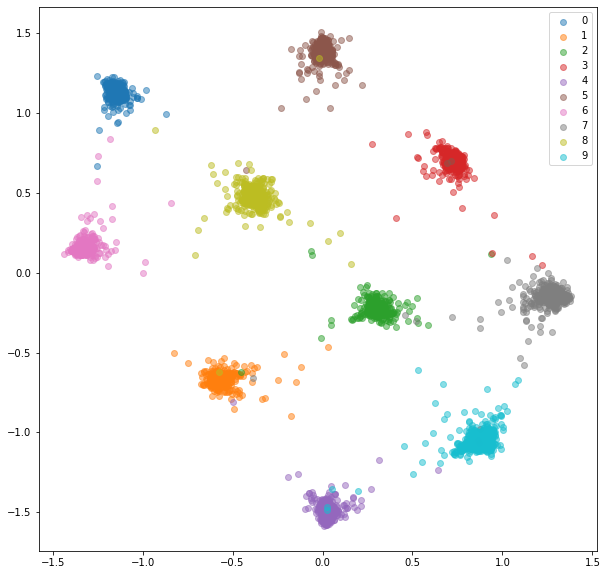

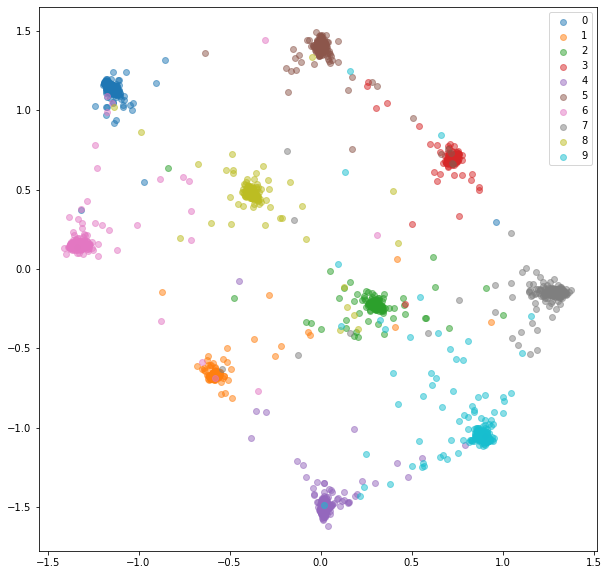

In [16]:
train_embeddings_cl, train_labels_cl = extract_embeddings(train_loader, model)
plot_embeddings(train_embeddings_cl, train_labels_cl)
val_embeddings_cl, val_labels_cl = extract_embeddings(test_loader, model)
plot_embeddings(val_embeddings_cl, val_labels_cl)

## Triplet Network

Now we'll train a triplet network, that takes an anchor, positive (same as anchor) and negative(different class than anchor) examples. The objective is to learn embeddings such that the anchor is closer to the positive example than it is to the negative example by some margin value.

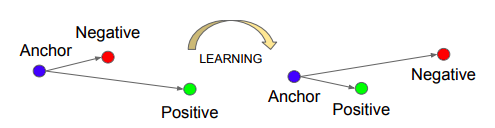

**Triplet Loss** : $$L_{triplet}(x_{a}, x_{p}, x_{n}) = max(0, m+\|f(x_{a}-f(x_{p})\|_{2}^{2} - \|f(x_{a})-f(x_{n})\|_{2}^{2})$$

In [23]:
# setting up dataloaders
from datasets import TripletMNIST

triplet_train_dataset = TripletMNIST(mnist_train_dataset)
triplet_test_dataset  = TripletMNIST(mnist_test_dataset)
batch_size = 128

kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
triplet_train_loader  = torch.utils.data.DataLoader(triplet_train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
triplet_test_loader   = torch.utils.data.DataLoader(triplet_test_dataset, batch_size=batch_size, shuffle=False, **kwargs)

# Setting up the networks
from networks import EmbeddingNet, TripletNet
from losses import TripletLoss

margin = 1
embedding_net = EmbeddingNet()
model         = TripletNet(embedding_net)

if cuda:
    model.cuda()
    
loss_fn = TripletLoss(margin)

lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs  = 20
log_interval = 100

In [27]:
fit(triplet_train_loader, triplet_test_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval)

Train: [0/60000 (0%)]	Loss: 0.452746
Train: [12800/60000 (21%)]	Loss: 0.236188
Train: [25600/60000 (43%)]	Loss: 0.122211
Train: [38400/60000 (64%)]	Loss: 0.094053
Train: [51200/60000 (85%)]	Loss: 0.070376
Epoch: 1/20. Train set: Average loss: 0.1213
Epoch: 1/20. Validation set: Average loss: 0.0559
Train: [0/60000 (0%)]	Loss: 0.066695
Train: [12800/60000 (21%)]	Loss: 0.048627
Train: [25600/60000 (43%)]	Loss: 0.044159
Train: [38400/60000 (64%)]	Loss: 0.043620
Train: [51200/60000 (85%)]	Loss: 0.037724
Epoch: 2/20. Train set: Average loss: 0.0430
Epoch: 2/20. Validation set: Average loss: 0.0424
Train: [0/60000 (0%)]	Loss: 0.049408
Train: [12800/60000 (21%)]	Loss: 0.038480
Train: [25600/60000 (43%)]	Loss: 0.032585
Train: [38400/60000 (64%)]	Loss: 0.028568
Train: [51200/60000 (85%)]	Loss: 0.032835
Epoch: 3/20. Train set: Average loss: 0.0319
Epoch: 3/20. Validation set: Average loss: 0.0435
Train: [0/60000 (0%)]	Loss: 0.000269
Train: [12800/60000 (21%)]	Loss: 0.021327
Train: [25600/60000 (

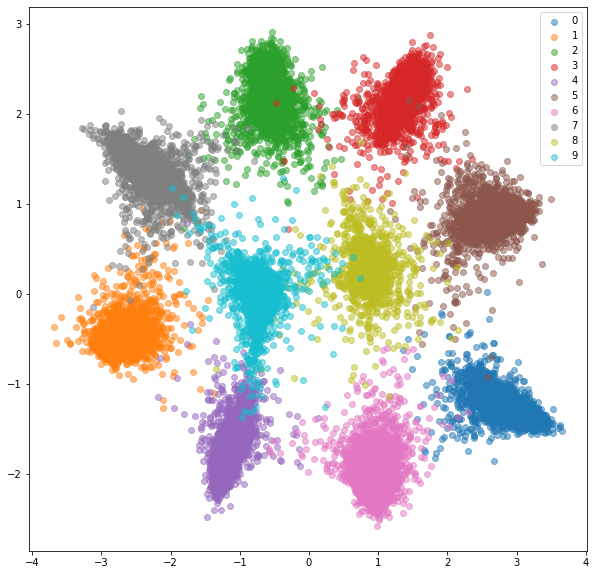

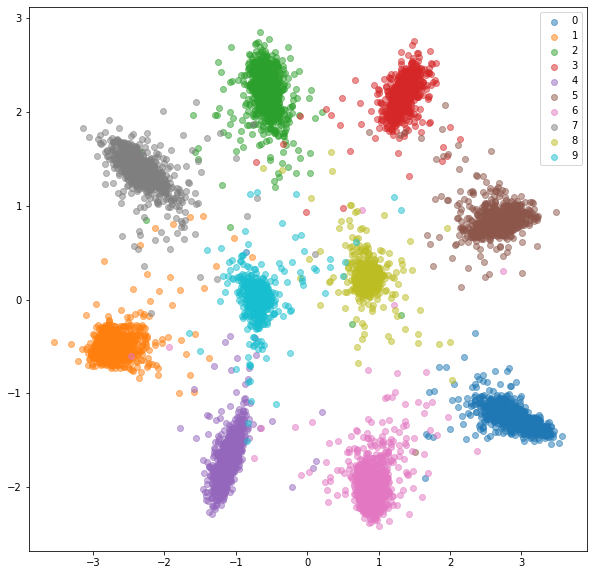

In [29]:
train_embeddings_tl, train_labels_tl = extract_embeddings(train_loader, model)
plot_embeddings(train_embeddings_tl, train_labels_tl)
val_embeddings_tl, val_labels_tl = extract_embeddings(test_loader, model)
plot_embeddings(val_embeddings_tl, val_labels_tl)

Contrastive loss clusters are separated more than triplet loss clusters. When classifying, contrastive loss clusters will give more accurate answers than the triplet loss.

**This concludes the experiment section for siamese networks and triplet loss**